<a href="https://colab.research.google.com/github/mahmudresin/Senior-Design-Project-499/blob/main/Copy_of_CSE499B_and_Mars_Data%20LAST%20DRAFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
yeaminmahmudresin_last_draft_path = kagglehub.dataset_download('yeaminmahmudresin/last-draft')

print('Data source import complete.')


100%|██████████| 61.4M/61.4M [00:01<00:00, 40.6MB/s]

Extracting files...


Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import kagglehub
import cv2

# Download dataset using kagglehub
yeaminmahmudresin_last_draft_path = kagglehub.dataset_download('yeaminmahmudresin/last-draft')

# Update paths to point to the downloaded dataset location
train_path = os.path.join(yeaminmahmudresin_last_draft_path, 'New Mars Experimental Data/Train')
test_path = os.path.join(yeaminmahmudresin_last_draft_path, 'New Mars Experimental Data/Test')
val_path = os.path.join(yeaminmahmudresin_last_draft_path, 'New Mars Experimental Data/Val')


def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
            img = cv2.resize(img, (4, 4))  # Resize to 4x4 to match 16 qubits
            images.append(img)
    return np.array(images)

train_images = load_images_from_folder(train_path)


# Preprocessing (unchanged)
def preprocess_images(image_dir, target_size=(64, 64)):
    images = []
    for img_file in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_file)
        img = load_img(img_path, target_size=target_size)
        img_array = img_to_array(img)
        images.append(img_array.flatten())
    return np.array(images)



train_images = load_images_from_folder(train_path)

# Load datasets
train_images = preprocess_images(train_path)
test_images = preprocess_images(test_path)
val_images = preprocess_images(val_path)

# Normalize features (unchanged)
scaler = MinMaxScaler()
train_images = scaler.fit_transform(train_images)
test_images = scaler.transform(test_images)
val_images = scaler.transform(val_images)

# Convert to binary (unchanged)
def to_binary_features(data, n_bits=8):
    binary_encoded = np.array([
        [np.binary_repr(int(val * (2**n_bits - 1)), width=n_bits) for val in sample]
        for sample in data
    ])
    return binary_encoded

train_binary = to_binary_features(train_images)
test_binary = to_binary_features(test_images)
val_binary = to_binary_features(val_images)

# Display sample binary encoding (unchanged)
print("Sample Binary Encoding of a Feature Vector:")
print(train_binary[0])

Sample Binary Encoding of a Feature Vector:
['01100010' '01100000' '01000000' ... '01110100' '01001101' '00110000']


In [5]:
import os
import cv2
import numpy as np



# Optional: Check the shape of the datasets
print(f'Train images shape: {train_images.shape}')
print(f'Test images shape: {test_images.shape}')
print(f'Validation images shape: {val_images.shape}')




Train images shape: (6732, 12288)
Test images shape: (200, 12288)
Validation images shape: (200, 12288)


In [6]:
import numpy as np

def normalize_images(images):
    return images.astype('float32') / 255.0

# Normalize the images
train_images = normalize_images(train_images)
test_images = normalize_images(test_images)
val_images = normalize_images(val_images)


In [9]:
from qiskit import QuantumCircuit
import numpy as np

# Example amplitude encoding function
def amplitude_encode(image):
    # Normalize the image to obtain a state vector
    amplitudes = image.flatten() / np.linalg.norm(image.flatten())
    num_qubits = int(np.ceil(np.log2(len(amplitudes))))  # Calculate required number of qubits

    qc = QuantumCircuit(num_qubits)

    # Amplitude encoding (this is a simplified version, for illustration purposes)
    for i in range(num_qubits):
        qc.ry(2 * np.arccos(amplitudes[i]), i)  # Encode amplitude into qubit
        if i > 0:
            qc.cx(i - 1, i)  # Create entanglement using 'cx' (CNOT)

    return qc

# Function to encode a batch of images
def batch_amplitude_encode(images):
    circuits = []
    for image in images:
        qc = amplitude_encode(image)
        circuits.append(qc)
    return circuits

# Example: Process a batch of 10 images from the training set
batch_size = 10
image_batch = train_images[:batch_size]  # Select the first 10 images
quantum_circuits = batch_amplitude_encode(image_batch)

# Draw the circuits for the first image in the batch
print(quantum_circuits[0].draw())


      ┌────────────┐                                                       »
 q_0: ┤ Ry(3.1261) ├──■────────────────────────────────────────────────────»
      ├────────────┤┌─┴─┐                                                  »
 q_1: ┤ Ry(3.1264) ├┤ X ├──■───────────────────────────────────────────────»
      ├────────────┤└───┘┌─┴─┐                                             »
 q_2: ┤ Ry(3.1315) ├─────┤ X ├──■──────────────────────────────────────────»
      ├────────────┤     └───┘┌─┴─┐                                        »
 q_3: ┤ Ry(3.1182) ├──────────┤ X ├──■─────────────────────────────────────»
      ├────────────┤          └───┘┌─┴─┐                                   »
 q_4: ┤ Ry(3.1235) ├───────────────┤ X ├──■────────────────────────────────»
      ├────────────┤               └───┘┌─┴─┐                              »
 q_5: ┤ Ry(3.1272) ├────────────────────┤ X ├──■───────────────────────────»
      ├────────────┤                    └───┘┌─┴─┐                         »

In [10]:
import numpy as np

def pad_image(image):
    num_qubits = 14  # Adjust the number of qubits according to your needs
    padded_size = 2 ** num_qubits
    padded_image = np.pad(image, (0, padded_size - len(image)))
    return padded_image

def amplitude_encoding_circuit(image):
    padded_image = pad_image(image)
    num_qubits = int(np.log2(len(padded_image)))
    qml.templates.AmplitudeEmbedding(padded_image, wires=range(num_qubits), normalize=True)
    return qml.state()

In [13]:
import pennylane as qml
import numpy as np

# Define the quantum device
dev = qml.device("default.qubit", wires=14)  # Adjust the number of wires based on your needs

@qml.qnode(dev)
def amplitude_encoding_circuit(image, num_qubits):
    padded_image = pad_image(image, num_qubits)
    qml.templates.AmplitudeEmbedding(padded_image, wires=range(num_qubits), normalize=True)
    return qml.state()

In [14]:
def pad_image(image, num_qubits):
    padded_size = 2 ** num_qubits
    padded_image = np.pad(image, (0, padded_size - len(image)), 'constant')
    return padded_image

In [15]:
# Example batch of images
image_batch = [np.random.rand(12288) for _ in range(10)]  # Replace with your actual images

# Execute the circuit for each image in the batch and store the results (statevectors)
results = [amplitude_encoding_circuit(image, num_qubits=14) for image in image_batch]

# Print the encoded statevectors for each image in the batch
for i, statevector in enumerate(results):
    print(f"Encoded statevector for image {i}: {statevector}")

Encoded statevector for image 0: [0.01376755+0.j 0.00291806+0.j 0.00066609+0.j ... 0.        +0.j
 0.        +0.j 0.        +0.j]
Encoded statevector for image 1: [0.00750561+0.j 0.00319431+0.j 0.01219672+0.j ... 0.        +0.j
 0.        +0.j 0.        +0.j]
Encoded statevector for image 2: [0.00594297+0.j 0.01295205+0.j 0.00975015+0.j ... 0.        +0.j
 0.        +0.j 0.        +0.j]
Encoded statevector for image 3: [0.01412985+0.j 0.00886771+0.j 0.00127067+0.j ... 0.        +0.j
 0.        +0.j 0.        +0.j]
Encoded statevector for image 4: [0.00244795+0.j 0.00092189+0.j 0.00654607+0.j ... 0.        +0.j
 0.        +0.j 0.        +0.j]
Encoded statevector for image 5: [1.02580858e-02+0.j 3.15552544e-03+0.j 4.11293927e-05+0.j ...
 0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j]
Encoded statevector for image 6: [0.01178201+0.j 0.0139958 +0.j 0.00513294+0.j ... 0.        +0.j
 0.        +0.j 0.        +0.j]
Encoded statevector for image 7: [0.01204148+0.j 0.01355902+0.j 0.

In [16]:
# Example: Measure the statevector
measurements = [qml.measure(qml.PauliZ(0)) for _ in range(len(results))]

In [17]:
import pennylane as qml
import numpy as np

# Set up the device for quantum computation (QPU)
dev = qml.device('default.qubit', wires=4)

# Define a quantum circuit for classification using Amplitude Embedding
@qml.qnode(dev)
def quantum_circuit(weights, x):
    # Amplitude encoding: we use the image data (x) as the input to the quantum circuit
    qml.templates.AngleEmbedding(x, wires=range(len(x)))

    # Define trainable quantum gates (variational circuit)
    qml.templates.BasicEntanglerLayers(weights, wires=range(len(x)))

    # Return expectation values (PauliZ measurements for each qubit)
    return [qml.expval(qml.PauliZ(i)) for i in range(len(x))]

# Function to encode and classify an image using the quantum circuit
def classify_image(image, weights):
    # Normalize the image to ensure the values are in the range [0, 1]
    normalized_image = image / np.linalg.norm(image)

    # Use the quantum circuit to classify
    return quantum_circuit(weights, normalized_image)

# Example of a random image (flattened and normalized) for testing
random_image = np.random.rand(4)  # For a 4-qubit system
random_weights = np.random.randn(1, 4)  # Random initialization for weights

# Classify the image
print("Quantum Classifier Output:", classify_image(random_image, random_weights))


Quantum Classifier Output: [0.522276643302952, 0.8187566954007308, 0.6252887097999857, 0.5211827617898366]


In [18]:
import numpy as np
import pennylane as qml

# Define the loss function (cross-entropy loss for classification)
def loss_fn(predictions, labels):
    # Use qml.math.exp for automatic differentiation compatibility
    predictions = 1 / (1 + qml.math.exp(-predictions))  # Sigmoid activation
    return -qml.math.mean(labels * qml.math.log(predictions) + (1 - labels) * qml.math.log(1 - predictions))

# Define a quantum circuit model with trainable parameters
def quantum_classifier(weights, image, num_qubits=16):
    # Define the quantum device
    dev = qml.device("default.qubit", wires=num_qubits)

    # Define the quantum circuit with trainable parameters
    @qml.qnode(dev, interface='autograd')  # Specify 'autograd' to enable automatic differentiation
    def circuit(weights, image):
        # Encode the image into quantum states using the weights as parameters
        for i in range(num_qubits):
            qml.RX(image[i], wires=i)
            qml.RZ(weights[i], wires=i)  # We make weights as trainable parameters

        # Measure the expectation value of the PauliZ operator (for simplicity)
        return qml.expval(qml.PauliZ(0))

    return circuit(weights, image)

# Training function
def train_classifier(images, labels, epochs=100, learning_rate=0.1):
    num_qubits = len(images[0])  # Number of qubits
    weights = np.random.randn(num_qubits)  # Initialize weights randomly

    # Ensure weights are trainable
    weights = np.array(weights, dtype=np.float64)

    for epoch in range(epochs):
        total_loss = 0
        # Perform a gradient descent step for each image
        for img, label in zip(images, labels):
            # Get predictions from quantum classifier
            pred = quantum_classifier(weights, img)  # Use the quantum classifier to get predictions

            # Compute the loss (negative log-likelihood)
            loss = loss_fn(pred, label)
            total_loss += loss

            # Compute the gradient of the loss w.r.t weights (using PennyLane’s automatic differentiation)
            # We use the fact that `qml.qnode` supports automatic differentiation
            gradient = qml.grad(loss_fn)(pred, label)

            # Update the weights using gradient descent
            weights -= learning_rate * gradient

        # Print progress
        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Loss = {total_loss / len(images)}")

    return weights

# Example images and labels (random for this case)
images = np.random.randn(10, 16)  # 10 samples, each with 16 features (qubits)
labels = np.random.randint(0, 2, size=10)  # Binary labels (0 or 1)

# Train the classifier
trained_weights = train_classifier(images, labels)
print("Trained weights:", trained_weights)


Epoch 0: Loss = 0.9420933002280474
Epoch 10: Loss = 0.942093300228047
Epoch 20: Loss = 0.9420933002280474
Epoch 30: Loss = 0.942093300228047
Epoch 40: Loss = 0.9420933002280473
Epoch 50: Loss = 0.942093300228047
Epoch 60: Loss = 0.9420933002280474
Epoch 70: Loss = 0.9420933002280473
Epoch 80: Loss = 0.942093300228047
Epoch 90: Loss = 0.9420933002280473
Trained weights: [-27.56992612 -29.08768374 -26.80164134 -26.81248382 -26.60054517
 -26.64564875 -27.47659536 -26.91591606 -27.25715934 -28.50975451
 -27.36429884 -27.86263174 -29.02168475 -25.66486202 -27.26318647
 -25.24826984]


In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pennylane as qml
import numpy as np

# Function to classify an image using the quantum circuit
def classify_image(image, weights, num_qubits):
    # Initialize the quantum device with the appropriate number of qubits
    dev = qml.device('default.qubit', wires=num_qubits)

    # Define the quantum circuit with the updated device
    @qml.qnode(dev)
    def quantum_circuit(weights, x):
        # Amplitude embedding of the image data
        qml.templates.AngleEmbedding(x, wires=range(num_qubits))

        # Reshape weights for one layer of the entanglement circuit
        weights_reshaped = weights.reshape((1, num_qubits))  # Assuming 1 layer for simplicity
        qml.templates.BasicEntanglerLayers(weights_reshaped, wires=range(num_qubits))

        # Return PauliZ expectation values
        return [qml.expval(qml.PauliZ(i)) for i in range(num_qubits)]

    # Normalize the image to ensure values are between [0, 1]
    normalized_image = image / np.linalg.norm(image)

    # Use the quantum circuit to classify the image
    result = quantum_circuit(weights, normalized_image)

    # Aggregate the output and classify based on the average result
    return 1 if np.mean(result) > 0 else 0  # Binary classification

# Function to evaluate the classifier on a dataset of images and labels
def evaluate_classifier(images, labels, weights):
    # Ensure all images have the same size and derive the number of qubits
    num_qubits = len(images[0])

    # Store predictions
    predictions = []

    # Classify each image
    for img in images:
        pred_class = classify_image(img, weights, num_qubits)
        predictions.append(pred_class)

    # Calculate evaluation metrics
    acc = accuracy_score(labels, predictions)
    prec = precision_score(labels, predictions)
    rec = recall_score(labels, predictions)
    f1 = f1_score(labels, predictions)

    return acc, prec, rec, f1

# Example of random data for testing
# Replace these with your actual dataset and trained weights
np.random.seed(42)
num_samples = 10
image_size = 4  # Number of qubits is equal to the number of features per image
images = np.random.rand(num_samples, image_size)  # Generate random images
labels = np.random.randint(0, 2, size=num_samples)  # Random binary labels
trained_weights = np.random.rand(image_size)  # Randomly initialized weights

# Evaluate the classifier on the dataset
acc, prec, rec, f1 = evaluate_classifier(images, labels, trained_weights)

# Print the evaluation results
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")



Accuracy: 0.5000
Precision: 0.5000
Recall: 1.0000
F1 Score: 0.6667


In [22]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np

# Classical CNN model for feature extraction
def classical_cnn(input_shape=(28, 28, 1)):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
    ])
    return model

# Quantum layer using the previously defined quantum classifier
def quantum_layer(image, weights):
    return classify_image(image.flatten(), weights)

# Define a hybrid model
def hybrid_model(input_shape=(28, 28, 1), num_qubits=4):
    # Create classical CNN model
    cnn_model = classical_cnn(input_shape)

    # Define the quantum weights (example initialization)
    quantum_weights = np.random.randn(1, num_qubits)

    # Create the input layer for the hybrid model
    inputs = layers.Input(shape=input_shape)

    # Get the output of the classical CNN
    cnn_output = cnn_model(inputs)

    # Specify the output shape of the Lambda layer based on the quantum layer's output
    quantum_output = layers.Lambda(lambda x: quantum_layer(x, quantum_weights),
                                   output_shape=(1,))(cnn_output)  # Output shape must be specified

    # Final classification layer (dense layer with sigmoid activation)
    output_layer = layers.Dense(1, activation='sigmoid')(quantum_output)

    # Define the full hybrid model
    model = models.Model(inputs=inputs, outputs=output_layer)

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Build and train the hybrid model
hybrid_model_instance = hybrid_model()
hybrid_model_instance.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 128)                 │         692,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               2 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 692,674 (2.64 MB)

 Trainable params: 692,674 (2.64 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
import tensorflow as tf

# Decorate the quantum circuit function to prevent AutoGraph transformation
@tf.autograph.experimental.do_not_convert
def quantum_circuit(inputs):
    # Quantum circuit operations (the same as before)
    for i in range(n_qubits):
        qml.RY(inputs[i], wires=i)

    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[2, 3])
    qml.RX(np.pi / 2, wires=0)
    qml.RX(np.pi / 2, wires=2)

    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Define Quantum Layer with suppressed warnings
class QuantumLayer(tf.keras.layers.Layer):
    def __init__(self, n_qubits):
        super(QuantumLayer, self).__init__()
        self.n_qubits = n_qubits

    def call(self, inputs):
        # Apply the quantum circuit to the inputs
        return tf.map_fn(quantum_circuit, inputs)


In [38]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
import pennylane as qml
import tensorflow as tf
tf.config.run_functions_eagerly(True)


# Example data placeholders (replace these with your actual data)
train_images = np.random.rand(100, 4)  # 100 training samples with 4 features each
test_images = np.random.rand(20, 4)    # 20 test samples with 4 features each
val_images = np.random.rand(20, 4)     # 20 validation samples with 4 features each

train_labels = np.random.randint(0, 2, size=(100,))  # Random binary labels for training
test_labels = np.random.randint(0, 2, size=(20,))    # Random binary labels for testing
val_labels = np.random.randint(0, 2, size=(20,))     # Random binary labels for validation

# Preprocessing (Normalization and One-Hot Encoding)
scaler = MinMaxScaler()

# Normalize the images
train_images = scaler.fit_transform(train_images)
test_images = scaler.transform(test_images)
val_images = scaler.transform(val_images)

# One-hot encode the labels
train_labels = to_categorical(train_labels, num_classes=2)
test_labels = to_categorical(test_labels, num_classes=2)
val_labels = to_categorical(val_labels, num_classes=2)

# Define Quantum Circuit
n_qubits = 4  # Adjust the number of qubits based on your problem
dev = qml.device('default.qubit', wires=n_qubits)

@qml.qnode(dev, interface="tf")
def quantum_circuit(inputs):
    # Apply quantum operations on the inputs
    for i in range(n_qubits):
        qml.RY(inputs[i], wires=i)

    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[2, 3])
    qml.RX(np.pi / 2, wires=0)
    qml.RX(np.pi / 2, wires=2)

    # Extract expectation values (PauliZ measurements)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

class QuantumLayer(tf.keras.layers.Layer):
    def __init__(self, n_qubits):
        super(QuantumLayer, self).__init__()
        self.n_qubits = n_qubits

    def call(self, inputs):
        # Apply the quantum circuit to each input using tf.map_fn
        output = tf.map_fn(lambda x: tf.convert_to_tensor(quantum_circuit(x), dtype=tf.float32), inputs)
        # Ensure output is a tensor and stack the results
        output = tf.stack(output, axis=0)
        return output

    def compute_output_shape(self, input_shape):
        # Define the shape of the output
        return (input_shape[0], self.n_qubits)


# Hybrid Model (Quantum + Dense layers)
model = Sequential([
    Input(shape=(train_images.shape[1],)),
    QuantumLayer(n_qubits),  # Quantum layer
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')  # Binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=20,
    batch_size=32
)

# Evaluate on test data
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_accuracy:.2f}")


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 991ms/step - accuracy: 0.4816 - loss: 0.6967 - val_accuracy: 0.5000 - val_loss: 0.6987
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.4842 - loss: 0.6975 - val_accuracy: 0.5500 - val_loss: 0.6971
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 961ms/step - accuracy: 0.5056 - loss: 0.6944 - val_accuracy: 0.3500 - val_loss: 0.6963
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 989ms/step - accuracy: 0.4983 - loss: 0.6928 - val_accuracy: 0.2500 - val_loss: 0.6960
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.5252 - loss: 0.6916 - val_accuracy: 0.5000 - val_loss: 0.6953
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 971ms/step - accuracy: 0.4967 - loss: 0.6919 - val_accuracy: 0.5000 - val_loss: 0.6948
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 970ms/step - accuracy: 0.4948 - loss: 0.6926 - val_accuracy: 0.5000 - val_loss: 0.6947
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.5207 - loss: 0.6904 - val_accuracy: 0.5000 - val_loss: 0.6949
Epoch 9/20
4

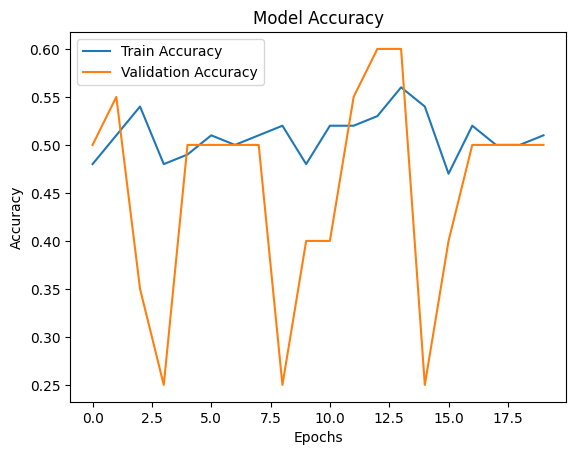

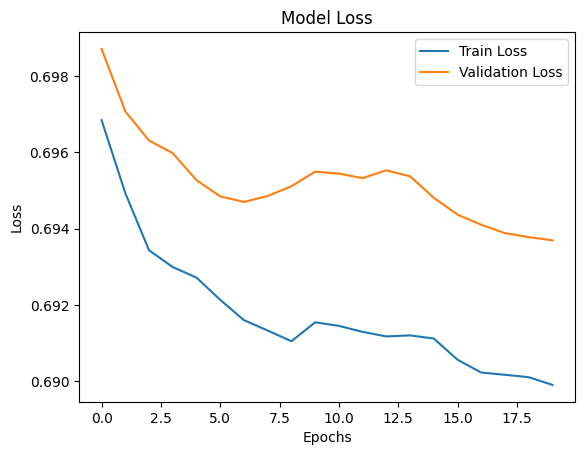

In [39]:
import matplotlib.pyplot as plt

# Plotting the training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()

# Plotting the training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.show()


In [40]:
model.save('quantum_hybrid_model.h5')


In [44]:
new_data = test_images[:5]
predictions = model.predict(new_data)
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
[[0.5092817  0.49071828]
 [0.5157175  0.48428246]
 [0.53190035 0.46809965]
 [0.5085787  0.49142125]
 [0.52086    0.47913992]]


In [47]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Input
from tensorflow.keras import layers

# Assuming your train_images is a NumPy array
# Reshape the images if they are not in the proper shape
train_images = train_images.reshape(-1, 64, 64, 1)  # Adjust the dimensions according to your image size

# Normalize image data
train_images = train_images / 255.0  # Normalize pixel values to be between 0 and 1

# ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the data generator to the training data
datagen.fit(train_images)

# Assuming you have corresponding labels for the training images (train_labels)
# Ensure train_labels are also NumPy arrays
train_labels = np.array(train_labels)  # Ensure this is in the correct format (e.g., one-hot encoded)

# Set up a learning rate scheduler
def scheduler(epoch, lr):
    if epoch > 10:
        return lr * 0.9  # Reduce learning rate by 10% after 10 epochs
    return lr

# Learning rate scheduler callback
lr_scheduler = LearningRateScheduler(scheduler)

# Define the model
model = Sequential([
    Input(shape=(64, 64, 1)),  # Adjust input shape according to your image size
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')  # Adjust the number of output classes (10 for example)
])

# Compile the model
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fit the model using the data generator
model.fit(datagen.flow(train_images, train_labels, batch_size=32),
          epochs=20,  # Number of epochs to train
          callbacks=[lr_scheduler],  # Apply learning rate scheduler
          verbose=2)


ValueError: cannot reshape array of size 400 into shape (64,64,1)

In [50]:
print(train_images)
print(train_images.shape)



[[0.8896862  0.57202921 0.83489626 0.9921034 ]
 [0.14932594 0.69674068 0.67557298 0.98034477]
 [0.98600464 0.69154028 0.24155491 0.79755024]
 [0.09172729 0.78743022 0.91330461 0.37863096]
 [0.62469368 0.42990414 0.43721053 0.30561124]
 [0.75853866 0.94599856 0.94409625 0.16897897]
 [0.87316582 0.74330214 0.25084903 0.06065567]
 [0.25557297 0.92155371 0.63413929 0.71945309]
 [0.24453418 0.72490013 0.02439079 0.37106115]
 [0.62074234 0.14021079 0.82543601 0.2296923 ]
 [0.64672645 0.40446261 0.59671629 0.10113048]
 [0.         0.91885734 0.26777184 0.81883382]
 [1.         0.20684441 0.263278   0.66081071]
 [0.96549229 0.92523152 0.50282583 0.79407818]
 [0.12095737 0.98808051 0.96788163 0.15784166]
 [0.28756061 0.09335584 0.26987562 0.81508399]
 [0.36786341 0.08136405 0.34093023 0.98178364]
 [0.62372496 0.41564438 0.16388102 0.98661397]
 [0.81830774 0.27828306 0.06666322 0.04991465]
 [0.10531494 0.58352463 0.93201587 0.49341694]
 [0.84079922 0.44596104 0.71012882 0.73035435]
 [0.15985842 

In [51]:
train_images = train_images.reshape(-1, 2, 2, 1)  # Example for 2x2 images (you will need to adjust this based on your actual data)
print(train_images.shape)  # Should now be (100, 2, 2, 1) if reshaped correctly



(100, 2, 2, 1)


In [54]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Step 1: Ensure your images are normalized and resized correctly
train_images = train_images / 255.0  # Normalize images to [0, 1] range
print(f"Training images shape: {train_images.shape}")

# Step 2: Data Augmentation (optional, helps with generalization)
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(train_images)

# Update the model for binary classification
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(2, 2, 1)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='sigmoid')  # For binary classification, use 2 units and sigmoid
])

# Compile the model (using binary cross-entropy loss for binary classification)
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Change to binary cross-entropy
              metrics=['accuracy'])

# Train the model
model.fit(datagen.flow(train_images, train_labels, batch_size=32),
          epochs=10,
          verbose=2)


# Reshape the test images to match the input shape of the model
test_images = test_images.reshape(-1, 2, 2, 1)  # Adjust the shape to (None, 2, 2, 1)
test_images = test_images / 255.0  # Normalize the images

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f"Test accuracy: {test_acc}")


Training images shape: (100, 2, 2, 1)
Epoch 1/10
4/4 - 0s - 117ms/step - accuracy: 0.5200 - loss: 0.6932
Epoch 2/10
4/4 - 0s - 107ms/step - accuracy: 0.5200 - loss: 0.6931
Epoch 3/10
4/4 - 0s - 72ms/step - accuracy: 0.5200 - loss: 0.6931
Epoch 4/10
4/4 - 0s - 66ms/step - accuracy: 0.5200 - loss: 0.6931
Epoch 5/10
4/4 - 0s - 71ms/step - accuracy: 0.5200 - loss: 0.6931
Epoch 6/10
4/4 - 0s - 62ms/step - accuracy: 0.5200 - loss: 0.6931
Epoch 7/10
4/4 - 0s - 78ms/step - accuracy: 0.5200 - loss: 0.6931
Epoch 8/10
4/4 - 0s - 74ms/step - accuracy: 0.5200 - loss: 0.6931
Epoch 9/10
4/4 - 0s - 75ms/step - accuracy: 0.5200 - loss: 0.6931
Epoch 10/10
4/4 - 0s - 72ms/step - accuracy: 0.5200 - loss: 0.6931
1/1 - 0s - 35ms/step - accuracy: 0.6000 - loss: 0.6926
Test accuracy: 0.6000000238418579


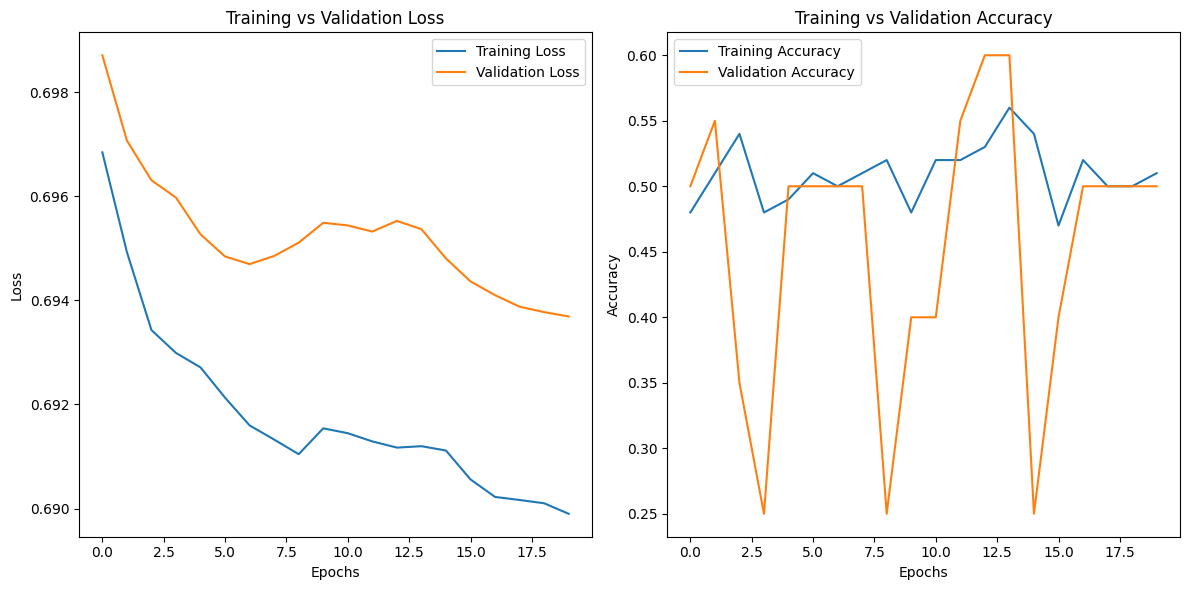

In [55]:
import matplotlib.pyplot as plt

# Assuming 'history' contains the training history of the model
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


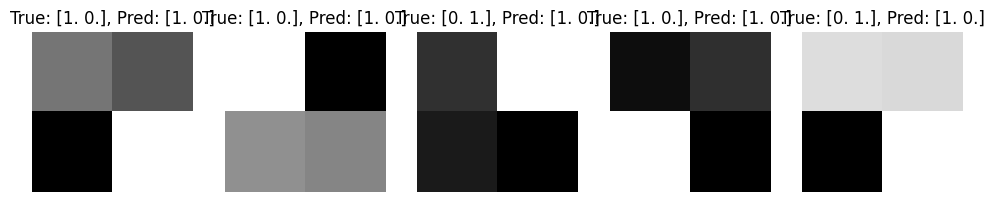

In [56]:
import numpy as np

# Get predictions for the test set
predictions = model.predict(test_images)

# For binary classification, round the predictions
predictions = np.round(predictions)

# Plot some sample predictions vs actual labels
plt.figure(figsize=(12, 6))

# Select the number of samples you want to plot
num_samples = 5

for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(test_images[i].reshape(2, 2), cmap='gray')  # Reshaping to match image size
    plt.title(f"True: {test_labels[i]}, Pred: {predictions[i]}")
    plt.axis('off')

plt.show()
